# Tracer Advection Initial Condition Definition

In order to define initial conditions on the cubed-sphere, we need to use some of the tools that have been described in `domain_decomposition_grid_generation.ipynb`. 
Specifically, we will need the `MetricTerms` portion of configuration in order to retrieve the coordinate information (latitude, longitude, dx, dy) and the `CubedSphereCommunicator` for gather data on tiles.

For tracer advection, initial conditions that need to be specified are for winds and pressure (which are held constant) and initial tracer concentration that will get advected.

In [2]:
import ipyparallel as ipp

cluster = ipp.Cluster(engines="mpi", n=6).start_and_connect_sync()
%autopx

Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

%autopx enabled


In [6]:
%%capture
nx = 20
ny = 20
nz = 79
""" (int): number of compute domain points per tile in each direction """

nhalo = 3
""" (int): number of halo points in x- and y- directions """

layout = (1, 1)
""" (int, int): how many parts each tile is split into along x- and y- directions """

backend = "numpy"
""" (str): gt4py backend name
    - other options? Untested. """

tracer_center = (0., 0.)
""" (float, float): longitude and latitude of tracer centerpoint"""

test_case = "b"
""" (string): 
    - a: fortran test_case1; 
    - b: similar to a, but less dispersive """

In [89]:
import functions as func
from mpi4py import MPI

mpi_comm = MPI.COMM_WORLD
mpi_size = mpi_comm.Get_size()
mpi_rank = mpi_comm.Get_rank()

namelistDict = func.store_namelist_variables(locals())
metadata, rank = func.define_metadata(namelistDict, mpi_comm)

configuration = func.configure_domain(mpi_comm, metadata["dimensions"])
communicator = configuration["communicator"]
metric_terms = configuration["metric_terms"]

[stderr:5] /home/ajdas/pace/pace-util/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


[stderr:2] /home/ajdas/pace/pace-util/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


Read in all the required coordinate variables: longitude and latitude on cell edges (`lon`, `lat`) and cell centeres (`lonA`, `latA`) and distances between grid corners in x and y (`dx`, `dy`).
We take the definitions of all these quantites on the compute domain and halo points in order to ensure a smooth transition between tiles.

In [247]:
from pace.util import Quantity

dimensions, origins, units = metadata["dimensions"], metadata["origins"], metadata["units"]

lonA = Quantity(
    data=metric_terms.lon_agrid.data,
    dims=("x_halo", "y_halo"),
    units=units["coord"],
    origin=origins["halo"],
    extent=(dimensions["nxhalo"], dimensions["nyhalo"]),
    gt4py_backend=backend,
)
latA = Quantity(
    data=metric_terms.lat_agrid.data,
    dims=("x_halo", "y_halo"),
    units=units["coord"],
    origin=origins["halo"],
    extent=(dimensions["nxhalo"], dimensions["nyhalo"]),
    gt4py_backend=backend,
)

lon = Quantity(
    data=metric_terms.lon.data,
    dims=("x_halo", "y_halo"),
    units=units["coord"],
    origin=origins["halo"],
    extent=(dimensions["nxhalo"], dimensions["nyhalo"]),
    gt4py_backend=backend,
)
lat = Quantity(
    data=metric_terms.lat.data,
    dims=("x_halo", "y_halo"),
    units=units["coord"],
    origin=origins["halo"],
    extent=(dimensions["nxhalo"], dimensions["nyhalo"]),
    gt4py_backend=backend,
)

dx = Quantity(
    data=metric_terms.dx.data,
    dims=("x_halo", "y_halo"),
    units=units["dist"],
    origin=origins["halo"],
    extent=(dimensions["nxhalo"], dimensions["nyhalo"]),
    gt4py_backend=backend,
)
dy = Quantity(
    data=metric_terms.dy.data,
    dims=("x_halo", "y_halo"),
    units=units["dist"],
    origin=origins["halo"],
    extent=(dimensions["nxhalo"], dimensions["nyhalo"]),
    gt4py_backend=backend,
)

## Streamfunction Definition

The streamfunction is defined so that the winds along the equator make one full rotation around the globe in 12 days.
Note that `streamfunction` is defined on cell corners and includes all the halo points, and `streamfunctionA` is defined on cell centers.

In [248]:
import numpy as np
from pace.util.constants import RADIUS

Ubar = (2.0 * np.pi * RADIUS) / (12. * 86400.)

streamfunction = -1 * Ubar * RADIUS * np.sin(lat)
streamfunctionA = -1 * Ubar * RADIUS * np.sin(latA)

streamfunction = Quantity(
    data=streamfunction,
    dims=("x_halo", "y_halo"),
    units=units["psi"],
    origin=origins["halo"],
    extent=(dimensions["nxhalo"], dimensions["nyhalo"]),
    gt4py_backend=backend,
    )
streamfunctionA = Quantity(
    data=streamfunctionA,
    dims=("x_halo", "y_halo"),
    units=units["psi"],
    origin=origins["halo"],
    extent=(dimensions["nxhalo"], dimensions["nyhalo"]),
    gt4py_backend=backend,
    )

## Calculating Winds from Streamfunction

The winds required by tracer advection are on a C-grid, so we calculate them from the streamfunction.

In [249]:
u_Cgrid = np.zeros(streamfunction.data.shape) * np.nan
u_Cgrid[:, :-1] = -1 * (streamfunction.data[:, 1:] - streamfunction.data[:, :-1]) / dy.data[:, :-1]

v_Cgrid = np.zeros(streamfunction.data.shape) * np.nan
v_Cgrid[:-1] = (streamfunction.data[1:] - streamfunction.data[:-1]) / dx.data[:-1]

u_Cgrid = Quantity(
    data=u_Cgrid,
    dims=("x", "y_interface"),
    units=units["wind"],
    origin=origins["compute_2d"],
    extent=(dimensions["nx"], dimensions["ny1"]),
    gt4py_backend=backend,
)
vC_Cgrid= Quantity(
    data=v_Cgrid,
    dims=("x_interface", "y"),
    units=units["wind"],
    origin=origins["compute_2d"],
    extent=(dimensions["nx1"], dimensions["ny"]),
    gt4py_backend=backend,
)

## Defining pressure thickness

The thickness field is initialized with a constant thickness of `10 Pa`.

In [250]:
delp = Quantity(
    data=np.ones((dimensions["nxhalo"], dimensions["nyhalo"])) * 10.,
    dims=("x", "y"),
    units=units["pressure"],
    origin=origins["compute_2d"],
    extent=(dimensions["nx"], dimensions["ny"]),
    gt4py_backend=backend,
)

## Defining the initial tracer state
We define the initial tracer state as a Gaussian blob centered on `tracer_center`. 
By default, the tracer is centered at the (0°N, 0°E), and has a maximum concentration of `1`.

In [251]:
from pace.util.grid.gnomonic import great_circle_distance_lon_lat

r0 = RADIUS / 3.0
gaussian_multiplier = np.zeros((dimensions["nxhalo"], dimensions["nyhalo"]))
p_center = [np.deg2rad(tracer_center[0]), np.deg2rad(tracer_center[1])]

for jj in range(dimensions["nyhalo"]):
    for ii in range(dimensions["nxhalo"]):
        p_dist = [lonA.data[ii, jj], latA.data[ii, jj]]

        r = great_circle_distance_lon_lat(
            p_center[0], p_dist[0], p_center[1], p_dist[1], RADIUS, np
        )
        
        gaussian_multiplier[ii, jj] = (
            0.5 * (1.0 + np.cos(np.pi * r / r0)) if r < r0 else 0.0
        )

tracer = Quantity(
    data=gaussian_multiplier * 1.,
    dims=("x", "y"),
    units=units["tracer"],
    origin=origins["compute_2d"],
    extent=(dimensions["nx"], dimensions["ny"]),
    gt4py_backend=backend,
)

## Casting everything into a single vertical layer
This is required by tracer advection in pace

In [252]:
dimensions["nz"] = 1
empty = np.zeros(
    (dimensions["nxhalo"] + 1, dimensions["nyhalo"] + 1, dimensions["nz"] + 1)
)

streamfunction_3d = np.copy(empty)
u_Cgrid_3d = np.copy(empty)
v_Cgrid_3d = np.copy(empty)
delp_3d = np.copy(empty)
tracer_3d = np.copy(empty)

streamfunction_3d[:, :, 0] = streamfunctionA.data
u_Cgrid_3d[:, :, 0] = u_Cgrid.data
v_Cgrid_3d[:, :, 0] = v_Cgrid.data
delp_3d[:-1, :-1, 0] = delp.data
tracer_3d[:-1, :-1, 0] = tracer.data

streamfunction = Quantity(
    data=streamfunction_3d,
    dims=("x", "y", "z"),
    units=units["psi"],
    origin=origins["compute_3d"],
    extent=(dimensions["nx"], dimensions["ny"], dimensions["nz"]),
    gt4py_backend=backend,
    )
u_Cgrid = Quantity(
    data=u_Cgrid_3d,
    dims=("x", "y_interface", "nz"),
    units=units["wind"],
    origin=origins["compute_3d"],
    extent=(dimensions["nx"], dimensions["ny1"], dimensions["nz"]),
    gt4py_backend=backend,
)
v_Cgrid= Quantity(
    data=v_Cgrid_3d,
    dims=("x_interface", "y", "nz"),
    units=units["wind"],
    origin=origins["compute_3d"],
    extent=(dimensions["nx1"], dimensions["ny"], dimensions["nz"]),
    gt4py_backend=backend,
)
delp = Quantity(
    data=delp_3d,
    dims=("x", "y", "z"),
    units=units["pressure"],
    origin=origins["compute_3d"],
    extent=(dimensions["nx"], dimensions["ny"], dimensions["nz"]),
    gt4py_backend=backend,
)
tracer = Quantity(
    data=tracer_3d,
    dims=("x", "y", "z"),
    units=units["tracer"],
    origin=origins["compute_3d"],
    extent=(dimensions["nx"], dimensions["ny"], dimensions["nz"]),
    gt4py_backend=backend,
)


## Plotting the initial condition

[output:0]

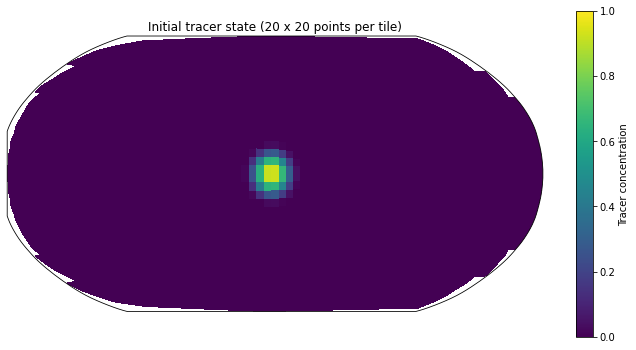

[output:0]

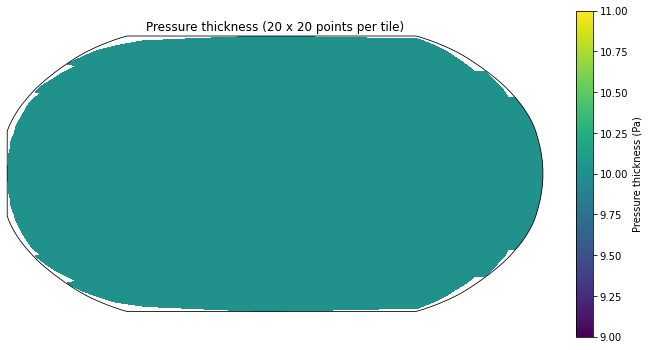

[output:0]

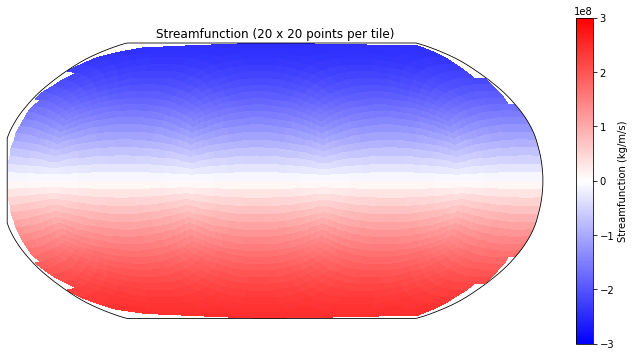

In [253]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from fv3viz import pcolormesh_cube

lon = Quantity(
    metric_terms.lon.data * 180 / np.pi,
    dims=("x_interface", "y_interface"),
    units=units["coord"],
    origin=origins["compute_2d"],
    extent=(dimensions["nx1"], dimensions["ny1"]),
    gt4py_backend=backend,
)

lat = Quantity(
    metric_terms.lat.data * 180 / np.pi,
    dims=("x_interface", "y_interface"),
    units=units["coord"],
    origin=origins["compute_2d"],
    extent=(dimensions["nx1"], dimensions["ny1"]),
    gt4py_backend=backend,
)

lon_gather = communicator.gather(lon)
lat_gather = communicator.gather(lat)

streamfunction_gather = communicator.gather(streamfunction)
delp_gather = communicator.gather(delp)
tracer_gather = communicator.gather(tracer)

if rank == 0:

    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    f1 = pcolormesh_cube(lat_gather.data, lon_gather.data, tracer_gather.data[:, :, :, 0],
        vmin=0, vmax=1, cmap='viridis')
    plt.colorbar(f1, label="Tracer concentration")
    ax.set_title("Initial tracer state (%s x %s points per tile)" % (nx, ny))

    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    f1 = pcolormesh_cube(lat_gather.data, lon_gather.data, delp_gather.data[:, :, :, 0],
        vmin=9, vmax=11, cmap='viridis')
    plt.colorbar(f1, label="Pressure thickness (Pa)")
    ax.set_title("Pressure thickness (%s x %s points per tile)" % (nx, ny))

    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    f1 = pcolormesh_cube(lat_gather.data, lon_gather.data, streamfunction_gather.data[:, :, :, 0],
        vmin=-3e8, vmax=3e8, cmap='bwr')
    plt.colorbar(f1, label="Streamfunction (kg/m/s)")
    ax.set_title("Streamfunction (%s x %s points per tile)" % (nx, ny))

    plt.show()

Since `u_Cgrid` and `v_Cgrid` are staggered fields, we need to unstagger them before plotting.
For simplicity, this is here done by removing the last point on the staggered dimension.

Also note that the u and v winds on the C-grid look strange because different tiles are oriented differently.

[output:0]

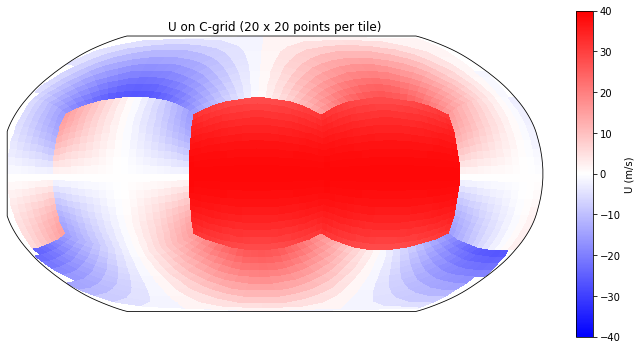

[output:0]

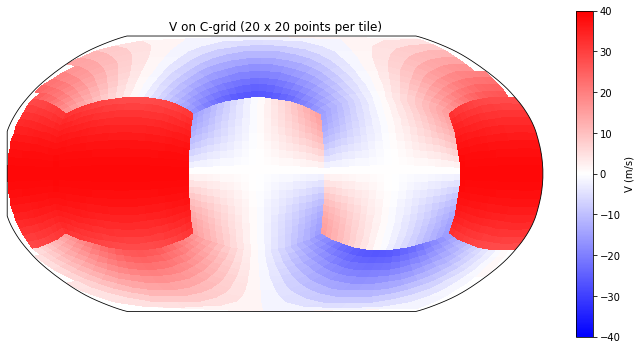

In [257]:
u_Cgrid_gather = communicator.gather(u_Cgrid)
v_Cgrid_gather = communicator.gather(v_Cgrid)

if rank == 0:

    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    f1 = pcolormesh_cube(lat_gather.data, lon_gather.data, u_Cgrid_gather.data[:, :, :-1, 0],
        vmin=-40, vmax=40, cmap='bwr')
    plt.colorbar(f1, label="U (m/s)")
    ax.set_title("U on C-grid (%s x %s points per tile)" % (nx, ny))

    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    f1 = pcolormesh_cube(lat_gather.data, lon_gather.data, v_Cgrid_gather.data[:, :-1, :, 0],
        vmin=-40, vmax=40, cmap='bwr')
    plt.colorbar(f1, label="V (m/s)")
    ax.set_title("V on C-grid (%s x %s points per tile)" % (nx, ny))

    plt.show()

In [243]:
u_Cgrid_gather.shape

Out[0:234]: (6, 20, 21, 1)

[5:execute]
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Input In [234], in <cell line: 1>()
----> 1 u_Cgrid_gather.shape

AttributeError: 'NoneType' object has no attribute 'shape'
[3:execute]
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Input In [234], in <cell line: 1>()
----> 1 u_Cgrid_gather.shape

AttributeError: 'NoneType' object has no attribute 'shape'
[4:execute]
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Input In [234], in <cell line: 1>()
----> 1 u_Cgrid_gather.shape

AttributeError: 'NoneType' object has no attribute 'shape'
[1:execute]
---------------------------------------------------------------------------
AttributeError                            Tra

AlreadyDisplayedError: 5 errors